In [1]:
import os
import pandas as pd
import json
import re
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [93]:
# Function to extract information from config.json
def extract_info_from_config(config_path):
    with open(config_path, 'r') as config_file:
        config_data = json.load(config_file)
        experiment_id = config_data.get('experiment_id', '')
        dataset = config_data.get('dataset', '')
        feature = config_data.get('feature', '')
        mode = config_data.get('mode', '')
        param = config_data.get('n_pins', '')
        deeper = config_data.get('deeper', '')
        try:
            manual = config_data.get('manual_lr', '')
            manual = 'Yes' if manual else 'No'
        except: 
            manual = 'No'
    return experiment_id, dataset, feature, mode, param, deeper, manual

# Function to parse the test_PinMNIST files
def parse_test(file_path):
    with open(file_path, 'r') as file:
        content = file.read().strip()
        parts = content.split('|')
        mse = float(parts[0].split(',')[0].split()[1])
        r2mse = float(parts[0].split(',')[1].split()[1])
        npp_part = parts[1].split(';')[0]
        gp_part = parts[1].split(';')[1]
        npp = float(npp_part.split(',')[0].split()[1])
        r2npp = float(npp_part.split(',')[1].split()[1])
        gp = float(gp_part.split(',')[0].split()[1])
        r2gp = float(gp_part.split(',')[1].split()[1])
    return mse, r2mse, npp, r2npp, gp, r2gp

def parse_res(file_path):
    with open(file_path, 'r') as file:
        content = file.read()  # Read the entire file content as a single string
    
    # Define the regular expression pattern to capture MSE, sigma, and the two float values
    pattern = r"MSE: ([\d.]+), R2: ([\d.-]+) \| NPP \(sigma ([\d.]+)\): ([\d.]+), R2: ([\d.-]+); GP: ([\d.]+), R2: ([\d.-]+)"
    
    # Find all matches in the content
    match = re.findall(pattern, content)[0]
    mse = float(match[0])  # Convert MSE value to float
    r2mse = float(match[1])
    sigma = float(match[2])  # Convert sigma value to float
    npp = float(match[3])  # Convert NPP value to float
    r2npp = float(match[4])
    gp = float(match[5])  # Convert GP value to float
    r2gp = float(match[6])
    
    return mse, r2mse, sigma, npp, r2npp, gp, r2gp

def append(exp_id, df, pp, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual='No'):
    return pd.concat([df, pd.DataFrame({
        'Experiment ID': [exp_id],
        'Dataset': [dataset],
        'Feature': [feature],
        'Extra layers': [deeper],
        'Manual LR': [manual],
        'Mode': [mode],
        'NPins': [param],
        'Partial Percent': [pp],
        'MSE': [mse],
        'R2 MSE': [r2mse], 
        'Sigma': [sigma],
        'NPP': [npp],
        'R2 NPP': [r2npp],
        'GP': [gp],
        'R2 GP': [r2gp]})], ignore_index=True)

In [94]:
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Experiment ID', 'Dataset', 'Feature', 'Extra layers', 'Mode', 'NPins', 'Partial Percent', 'MSE', 'R2 MSE', 'Sigma', 'NPP', 'R2 NPP', 'GP', 'R2 GP'])

# Directory containing the folders
base_folders = ['./history/P100_normal']

for base_folder in base_folders:
    # Loop through each directory in the base folder
    for dir_name in os.listdir(base_folder):
        if dir_name.startswith('17') or dir_name.startswith('mesh') or dir_name.startswith('random'):
            dir_path = os.path.join(base_folder, dir_name)

            # Check if the item in the base folder is a directory
            if os.path.isdir(dir_path):
                # Get config.json info
                config_path = os.path.join(dir_path, 'config.json')
                exp_id, dataset, feature, mode, param, deeper, manual = extract_info_from_config(config_path)
                mse, r2mse, sigma, npp, r2npp, gp, r2gp = parse_res(os.path.join(dir_path, 'results.txt'))
                df = append(exp_id, df, 0.0, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual)

                # Loop through files starting with 'test_PinMNIST'
                for file_name in os.listdir(dir_path):
                    if file_name.startswith('test_PinMNIST') or file_name.startswith('test_Synthetic') or file_name.startswith('test_Building'):
                        pp = float(file_name.split('_')[-1][:-4])
                        file_path = os.path.join(dir_path, file_name)
                        mse, r2mse, npp, r2npp, gp, r2gp = parse_test(file_path)
                        df = append(exp_id, df, pp, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual)

In [95]:
df = pd.concat([df, pd.DataFrame({
        'Experiment ID': [None, None, None, None, None, None],
        'Dataset': ['Building', 'Building', 'Building', 'Building', 'Building', 'Building'],
        'Feature': ['AE', 'AE', 'AE', 'AE', 'AE', 'AE'],
        'Extra layers': [True, True, True, True, True, True],
        'Manual LR': ['No', 'No', 'No', 'No', 'No', 'No'],
        'Mode': ['mesh', 'mesh', 'mesh', 'random', 'random', 'random'],
        'NPins': [16, 121, 225, 10, 100, 200],
        'Partial Percent': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        'MSE': [0.461, 0.423, 1.302, 0.678, 0.548, 0.509],
        'R2 MSE': [0.129, 0.251, -0.215, -0.192, 0.059, 0.063], 
        'Sigma': [0.1, 0.1, 2.0, 2.0, 0.2, 0.2],
        'NPP': [0.463, 0.472, 0.355, 0.572, 0.442, 0.488],
        'R2 NPP': [0.248, 0.220, 0.174, 0.131, 0.243, 0.117],
        'GP': [0.463, 0.472, 0.355, 0.571, 0.416, 0.468],
        'R2 GP': [0.248, 0.211, 0.174, 0.099, 0.261, 0.178]})], ignore_index=True)

In [96]:
df = pd.concat([df, pd.DataFrame({
        'Experiment ID': [None, None, None, None],
        'Dataset': ['Building', 'Building', 'Building', 'Building'],
        'Feature': ['DDPM', 'DDPM', 'DDPM', 'DDPM'],
        'Extra layers': [True, True, True, True],
        'Manual LR': ['Yes', 'Yes', 'Yes', 'Yes'],
        'Mode': ['mesh', 'mesh', 'random', 'random'],
        'NPins': [16, 121, 10, 100],
        'Partial Percent': [1.0, 1.0, 1.0, 1.0],
        'MSE': [1.355, 1.579, 2.032, 1.816],
        'R2 MSE': [0.11, -0.190, -0.216, -0.205], 
        'Sigma': [0.1, 0.1, 2.0, 2.0],
        'NPP': [0.784, 1.108, 1.564, 0.975],
        'R2 NPP': [-0.140, -1.862, -0.233, -2.117],
        'GP': [0.784, 1.108, 1.560, 0.944],
        'R2 GP': [-0.140, -1.862, -0.230, -2.055]})], ignore_index=True)

In [5]:
df['NPins'].unique()

array([100, 9, 10, 16, 121, 225, 200], dtype=object)

In [13]:
df[(df['Dataset'] == 'PinMNIST') & (df['Partial Percent'] != 0.00) & (df['Feature'] == 'AE')].drop(labels=['Extra layers', 'Manual LR'], axis=1)

,Experiment ID,Dataset,Feature,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
6,1711040029,PinMNIST,AE,mesh,100,1.00,0.143749,0.997565,1.0,0.135252,0.997674,0.134763,0.997683
7,1711040029,PinMNIST,AE,mesh,100,0.75,0.143749,0.997565,1.0,0.135252,0.997674,0.134896,0.997681
8,1711040029,PinMNIST,AE,mesh,100,0.50,0.143749,0.997565,1.0,0.135252,0.997674,0.134992,0.997679
9,1711040029,PinMNIST,AE,mesh,100,0.25,0.143749,0.997565,1.0,0.135252,0.997674,0.135144,0.997677
11,1710256927,PinMNIST,AE,mesh,9,1.00,0.087576,0.989380,0.2,0.070190,0.996840,0.070190,0.974519
12,1710256927,PinMNIST,AE,mesh,9,0.75,0.087576,0.989380,0.2,0.070190,0.996840,0.070190,0.974519
13,1710256927,PinMNIST,AE,mesh,9,0.50,0.087576,0.989380,0.2,0.070190,0.996840,0.070190,0.978983
14,1710256927,PinMNIST,AE,mesh,9,0.25,0.087576,0.989380,0.2,0.070190,0.996840,0.070190,0.978983
16,1711030826,PinMNIST,AE,random,100,1.00,0.299582,0.995140,0.1,0.255289,0.995766,0.250009,0.995802
17,1711030826,PinMNIST,AE,random,100,0.75,0.299582,0.995140,0.1,0.255289,0.995766,0.254347,0.995765


In [12]:
df.sort_values(by=['NPins', 'Partial Percent', 'Extra layers', 'Manual LR'], inplace=True, ascending=False, ignore_index=True)
df.sort_values(by=['Dataset', 'Feature', 'Mode'], inplace=True, ignore_index=True)
df.drop_duplicates(subset=['Dataset', 'Feature', 'Extra layers', 'Mode', 'NPins', 'Partial Percent', 'Manual LR'], keep='last', inplace=True)
#df.to_csv('data.csv', index=False)

In [155]:
df.sort_values(by=['NPins', 'Partial Percent', 'Extra layers', 'Manual LR'], inplace=True, ascending=False, ignore_index=True)
df.sort_values(by=['Dataset', 'Mode'], inplace=True, ignore_index=True)
df[(df['Dataset'] == 'PinMNIST') & (df['Partial Percent'] == 0.00)].drop(labels=['Extra layers', 'Manual LR', 'Sigma', 'R2 NPP', 'NPP'], axis=1)

,Experiment ID,Dataset,Feature,Mode,NPins,Partial Percent,MSE,R2 MSE,GP,R2 GP
14,1710267658,PinMNIST,DDPM,mesh,100,0.0,9.995679,0.820262,10.131638,0.828189
15,1710251634,PinMNIST,AE,mesh,100,0.0,0.146703,0.997413,0.168137,0.997134
24,1710272272,PinMNIST,DDPM,mesh,9,0.0,12.655195,-7.653552,15.303368,-5.005589
25,1710256927,PinMNIST,AE,mesh,9,0.0,118.606788,-0.641429,0.070190,0.996840
34,1710262488,PinMNIST,AE,random,100,0.0,72.779434,-0.122882,0.373429,0.993797
35,1710281017,PinMNIST,DDPM,random,100,0.0,12.129181,0.806282,12.487945,0.801037
44,1710274493,PinMNIST,DDPM,random,10,0.0,15.651435,-79.367118,16.405451,-36.027748
45,1710259746,PinMNIST,AE,random,10,0.0,1.068728,0.946300,0.861110,0.942477


In [50]:
df[(df['Partial Percent'] == 1.0) & (df['Dataset'] == 'Synthetic')].drop(labels=['Partial Percent', 'Extra layers', 'Manual LR'], axis=1).reset_index(drop=True) 

,Experiment ID,Dataset,Feature,Mode,NPins,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
0,1710114794,Synthetic,AE,mesh,100,12.861979,0.799551,1.0,12.586907,0.803550,12.430888,0.806026
1,1710124555,Synthetic,AE,mesh,9,12.466903,0.552812,0.2,12.467339,0.552791,12.467339,0.552791
2,1710263797,Synthetic,AE,random,100,60.962908,0.230757,0.1,48.258456,0.393546,44.520064,0.446597
3,1710129559,Synthetic,AE,random,10,58.034090,-0.394917,1.0,55.255789,-0.334257,54.258789,-0.326165
4,1710280733,Synthetic,DDPM,mesh,100,62.171049,0.043919,0.5,10.526485,0.835883,10.420147,0.837574
5,1710284556,Synthetic,DDPM,mesh,9,87.587199,-0.284398,2.0,12.468908,0.552771,12.468908,0.552771
6,1710291204,Synthetic,DDPM,random,100,81.548449,-0.029261,0.2,29.319842,0.643262,29.721956,0.642007
7,1710287608,Synthetic,DDPM,random,10,46.664181,-0.170590,0.1,23.469576,0.374352,22.961709,0.389703


In [223]:
mode_npins_combinations

[('mesh', 9), ('mesh', 100), ('random', 10), ('random', 100)]

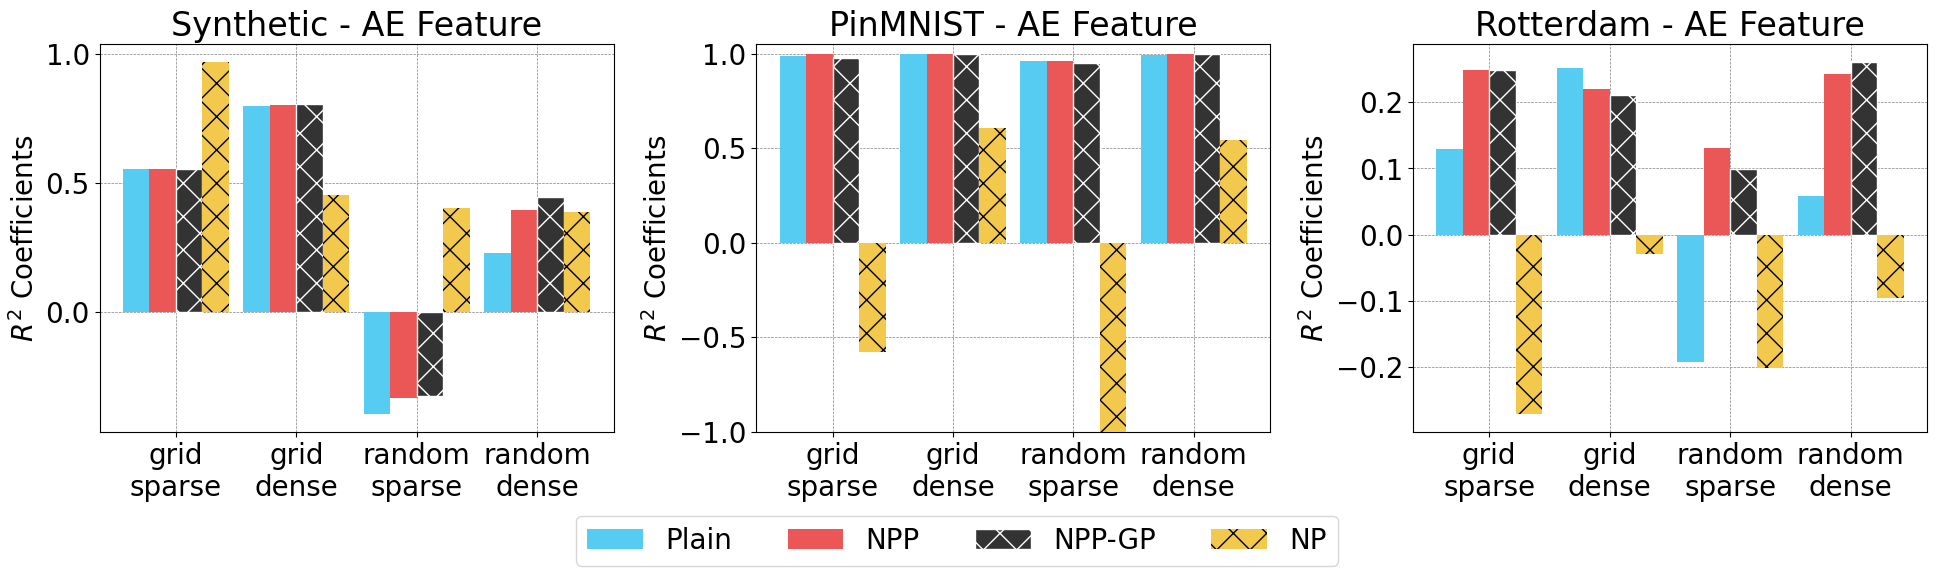

In [98]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'size': 20}
matplotlib.rc('font', **font)
#plt.rcParams['text.usetex'] = True

# Assuming 'df' is your DataFrame, ensure it's correctly loaded or defined above this block
# Filter data for the feature AE
feature_data = df[df['Feature'] == 'AE']

# Separate data by dataset
datasets = ['Synthetic', 'PinMNIST', 'Building']
colors = ["#56CCF2", "#EB5757", "#333333", "#F2C94C"]
patterns = [None, None, "x", "x"] #["/", "\\", "x", "."]
labels = ["grid\nsparse", "grid\ndense", "random\nsparse", "random\ndense"]

# Assuming 'r2_nps' is correctly defined as per your context
r2_nps = [[0.969, 0.452, 0.405, 0.388], [-0.576, 0.607, -200.553, 0.546], [-0.271, -0.029, -0.202, -0.0958]] #-0.113 -0.032

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(20, 6))

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    dataset_data = feature_data[feature_data['Dataset'] == dataset]
    
    if dataset != 'Building':
        mode_npins_combinations = dataset_data.groupby(['Mode', 'NPins']).size().index.tolist()
        mode_npins_combinations = sorted(mode_npins_combinations, key=lambda x: (x[0], x[1]))
    else:
        mode_npins_combinations = [('mesh', 16), ('mesh', 121), ('random', 10), ('random', 100)]
    
    #labels = [f"random\n{npins}" if mode == 'random' else f"grid\n{npins}" for mode, npins in mode_npins_combinations]
    x = np.arange(len(labels))  # the label locations
    
    width = 0.22  # Decreased width for slight whitespace between bars
    
    # Assuming these lists are populated correctly from your dataset
    r2_mse = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 MSE'].values[0] for mode, npins in mode_npins_combinations]
    r2_npp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 NPP'].values[0] for mode, npins in mode_npins_combinations]
    r2_gp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 GP'].values[0] for mode, npins in mode_npins_combinations]
    r2_np = r2_nps[i]
    
    # Adjusted positions for a small whitespace between bars
    rects1 = ax.bar(x - 1.5*width, r2_mse, width, label='Plain', color=colors[0], hatch=patterns[0], zorder=3)
    rects2 = ax.bar(x - 0.5*width, r2_npp, width, label='NPP', color=colors[1], hatch=patterns[1], zorder=3)
    rects3 = ax.bar(x + 0.5*width, r2_gp, width, label='NPP-GP', color=colors[2], hatch=patterns[2], edgecolor='#FFFFFF', zorder=3)
    rects4 = ax.bar(x + 1.5*width, r2_np, width, label='NP', color=colors[3], hatch=patterns[3], zorder=3)

    ax.set_ylabel('$R^2$ Coefficients')
    if dataset == 'Building':
        dataset = 'Rotterdam'
    ax.set_title(f'{dataset} - AE Feature')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    if i == 1:
        ax.set_ylim([-1, 1.05])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
#fig.suptitle('$R^2$ analysis for different densities')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("AE_barplot_pp1.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()


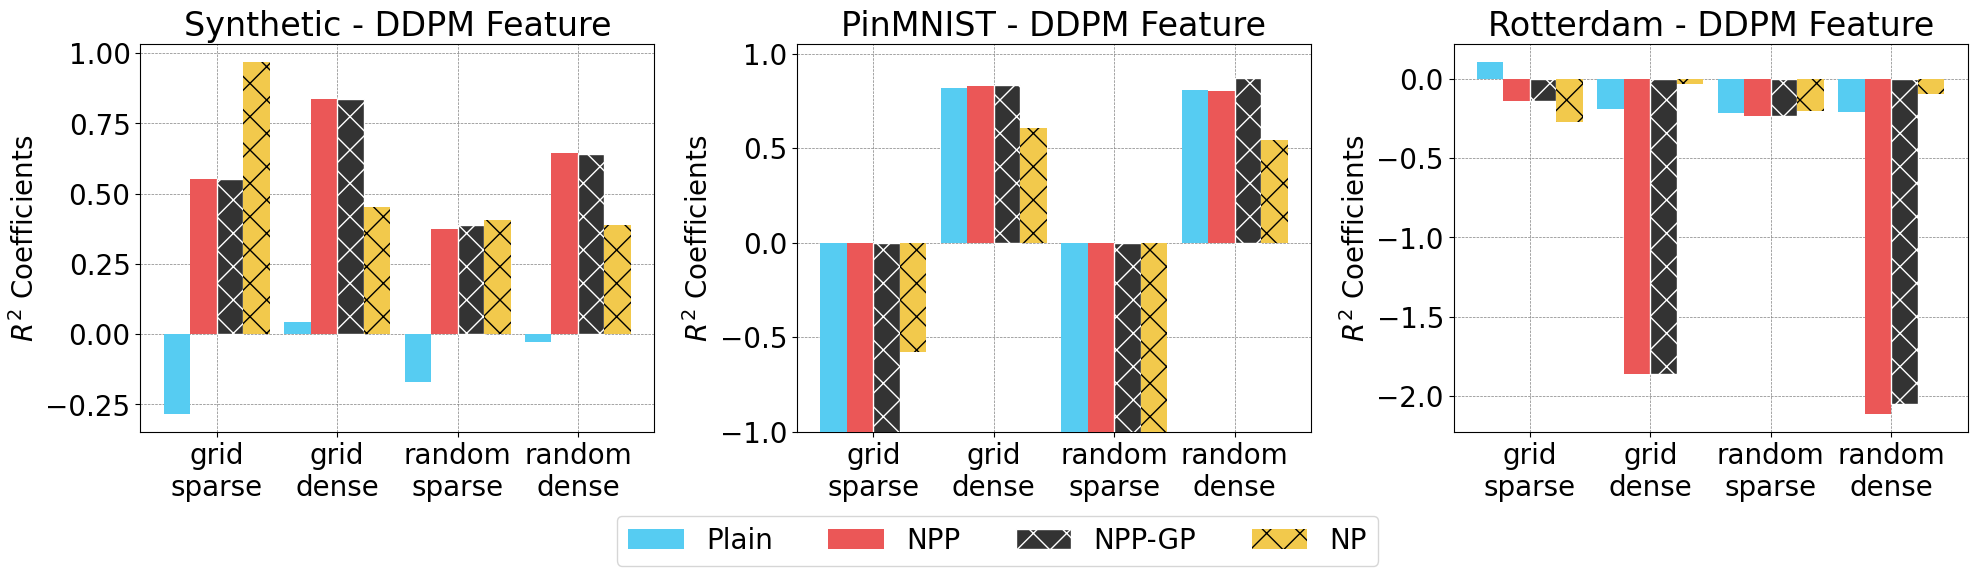

In [97]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'size': 20}
matplotlib.rc('font', **font)
#plt.rcParams['text.usetex'] = True

# Assuming 'df' is your DataFrame, ensure it's correctly loaded or defined above this block
# Filter data for the feature AE
feature_data = df[df['Feature'] == 'DDPM']

# Separate data by dataset
datasets = ['Synthetic', 'PinMNIST', 'Building']
colors = ["#56CCF2", "#EB5757", "#333333", "#F2C94C"]
patterns = [None, None, "x", "x"] #["/", "\\", "x", "."]
labels = ["grid\nsparse", "grid\ndense", "random\nsparse", "random\ndense"]

# Assuming 'r2_nps' is correctly defined as per your context
r2_nps = [[0.969, 0.452, 0.405, 0.388], [-0.576, 0.607, -200.553, 0.546], [-0.271, -0.029, -0.202, -0.0958]] #-0.113 -0.032

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(20, 6))

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    dataset_data = feature_data[feature_data['Dataset'] == dataset]
    
    if dataset != 'Building':
        mode_npins_combinations = dataset_data.groupby(['Mode', 'NPins']).size().index.tolist()
        mode_npins_combinations = sorted(mode_npins_combinations, key=lambda x: (x[0], x[1]))
    else:
        mode_npins_combinations = [('mesh', 16), ('mesh', 121), ('random', 10), ('random', 100)]
    
    #labels = [f"random\n{npins}" if mode == 'random' else f"grid\n{npins}" for mode, npins in mode_npins_combinations]
    x = np.arange(len(labels))  # the label locations
    
    width = 0.22  # Decreased width for slight whitespace between bars
    
    # Assuming these lists are populated correctly from your dataset
    r2_mse = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 MSE'].values[0] for mode, npins in mode_npins_combinations]
    r2_npp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 NPP'].values[0] for mode, npins in mode_npins_combinations]
    r2_gp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 GP'].values[0] for mode, npins in mode_npins_combinations]
    r2_np = r2_nps[i]
    
    # Adjusted positions for a small whitespace between bars
    rects1 = ax.bar(x - 1.5*width, r2_mse, width, label='Plain', color=colors[0], hatch=patterns[0], zorder=3)
    rects2 = ax.bar(x - 0.5*width, r2_npp, width, label='NPP', color=colors[1], hatch=patterns[1], zorder=3)
    rects3 = ax.bar(x + 0.5*width, r2_gp, width, label='NPP-GP', color=colors[2], hatch=patterns[2], edgecolor='#FFFFFF', zorder=3)
    rects4 = ax.bar(x + 1.5*width, r2_np, width, label='NP', color=colors[3], hatch=patterns[3], zorder=3)

    ax.set_ylabel('$R^2$ Coefficients')
    if dataset == 'Building':
        dataset = 'Rotterdam'
    ax.set_title(f'{dataset} - DDPM Feature')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    if i == 1:
        ax.set_ylim([-1, 1.05])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
#fig.suptitle('$R^2$ analysis for different densities')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("DDPM_barplot_pp1.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()


In [16]:
# NP Results
Synthetic_NP = {
 "mesh_sparse": [0.969, 0.971, 0.972, 0.969],  # Grid Sparse
 "mesh_dense": [0.408, 0.440, 0.448, 0.452],   # Grid Dense
 "random_sparse": [0.418, 0.412, 0.416, 0.405], # Random Sparse
 "random_dense": [0.306, 0.357, 0.385, 0.388]   # Random Dense
}

PinMNIST_NP = {
 "mesh_sparse": [-0.576, -0.577, -0.576, -0.576],  # Grid Sparse
 "mesh_dense": [0.535, 0.580, 0.600, 0.607],       # Grid Dense
 "random_sparse": [-125.973, -131.527, -252.488, -200.553], # Random Sparse
 "random_dense": [0.459, 0.518, 0.534, 0.546]               # Random Dense
}

Rotterdam_NP = {
 "mesh_sparse": [-0.326, -0.245, -0.270, -0.271],  # Grid Sparse
 "mesh_dense": [-0.134, -0.059, -0.031, -0.029],  # Grid Dense
 "mesh_ultradense": [-0.201, -0.128, -0.121, -0.113],  # Grid Ultradense
 "random_sparse": [-0.200, -0.203, -0.211, -0.202], # Random Sparse
 "random_dense": [-0.121, -0.102, -0.101, -0.096], # Random Dense
 "random_ultradense": [-0.057, -0.041, -0.034, -0.032] # Random Ultradense
}

NP = [Synthetic_NP, PinMNIST_NP, Rotterdam_NP]


In [17]:
x = [0.25, 0.50, 0.75, 1.00]

Rotterdam_NPP_GP = {
 "mesh_sparse": [0.248, 0.248, 0.248, 0.248],  # Grid Sparse
 "mesh_dense": [0.211, 0.211, 0.211, 0.211],  # Grid Dense
 "mesh_ultradense": [0.174, 0.174, 0.174, 0.174],   # Grid Ultradense
 "random_sparse": [0.126, 0.121, 0.108, 0.099], # Random Sparse
 "random_dense": [0.251, 0.255, 0.256, 0.261], # Random Dense
 "random_ultradense": [0.132, 0.142, 0.162, 0.178]  # Random Ultradense
}

NPP_GP = [None, None, Rotterdam_NPP_GP]


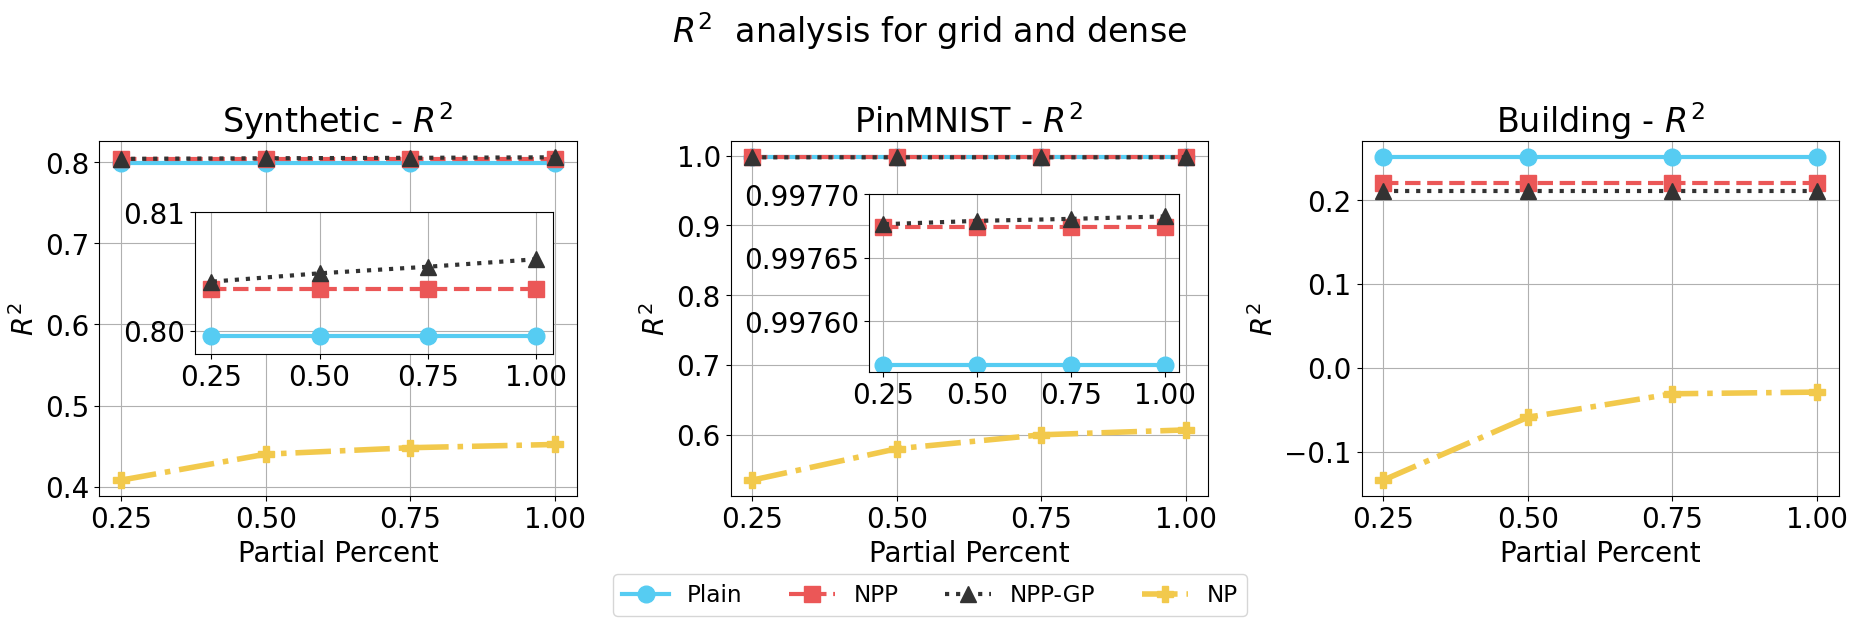

In [83]:
# Correcting the variable naming conflict and trying again
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

font = {'size': 20}

matplotlib.rc('font', **font)

# Filter the DataFrame for rows where Feature is equal to "AE"
df_ae = df[(df['Feature'] == 'AE')]

# Settings for visualization
metrics = ['R2']
data_groups = ['MSE', 'NPP']
data_names = ['Plain', 'NPP']
datasets = ['Synthetic', 'PinMNIST', 'Building']
modes = ['mesh'] #df_ae['Mode'].unique()
npins = [100] #df_ae['NPins'].unique()
mode_name = 'random' if modes[0] == 'random' else 'grid'
density = 'dense' if npins[0] == 100 else 'sparse'
#colors = sns.color_palette("tab10", n_colors=len(modes)*len(npins))
colors= ["#56CCF2", "#EB5757", "#333333", "#F2C94C"] #["#56CCF2", None, "#EB5757", None, "#333333", "#F2C94C"]
linestyles = ['-', '--', ':', '-.']
markers = ['o', 's', '^', 'P']
fig, axs = plt.subplots(len(metrics), len(datasets), figsize=(19, 6), sharex=True)
# Function to plot the lines, with fixed variable naming
def plot_lines(ax, k, metric, only_GP = False):
    if not only_GP:       
        if k == 2 and modes[0] == 'mesh':
            if npins[0] == 9:
                npins[0] = 16
            if npins[0] == 100:
                npins[0] = 121
        for mode_idx, mode in enumerate(modes):
            for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
                for data_group_idx, data_group in enumerate(data_groups):
                    # Filter the dataset for the specific conditions
                    df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                        (df_ae['NPins'] == npins_value)]
                    if df_filtered.empty:
                        print('HEY')
                    label = data_names[data_group_idx]
                    color = colors[data_group_idx] #colors[mode_idx * len(npins) + list(sorted(npins)).index(npins_value)]
                    linestyle = linestyles[data_group_idx] #linestyles[data_group_idx]
                    marker =  markers[data_group_idx] #markers[data_group_idx]
                    value = df_filtered[df_filtered['Partial Percent'] == 1.0][data_group].values[0] if metric == 'MSE' else df_filtered[df_filtered['Partial Percent'] == 1.0][f'R2 {data_group}'].values[0]
                    ax.plot(x, [value]*len(x),
                            label=label, color=color, linestyle=linestyle, marker=marker, markersize=12, linewidth=3)
        if k == 2:
            ax.plot(x, NPP_GP[j][f"{modes[0]}_{density}"],
                            label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)
        else:
            df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                        (df_ae['NPins'] == npins_value)]
            ax.plot(df_filtered[df_filtered['Partial Percent'] != 0.0]['Partial Percent'], df_filtered[df_filtered['Partial Percent'] != 0.0][f'R2 GP'],
                            label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)



        ax.plot(x, NP[j][f"{modes[0]}_{density}"],
                            label="NP", color=colors[3], linestyle=linestyles[3], marker=markers[3], markersize=12, linewidth=4)
    else:
        if k == 2 and modes[0] == 'mesh':
            if npins[0] == 9:
                npins[0] = 16
            if npins[0] == 100:
                npins[0] = 121
        for mode_idx, mode in enumerate(modes):
            for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
                for data_group_idx, data_group in enumerate(data_groups):
                    if k == 2:
                        ax.plot(x, NPP_GP[j][f"{modes[0]}_{density}"],
                                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)
                    else:
                        df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                                    (df_ae['NPins'] == npins_value)]
                        ax.plot(df_filtered[df_filtered['Partial Percent'] != 0.0]['Partial Percent'], df_filtered[df_filtered['Partial Percent'] != 0.0][f'R2 GP'],
                                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)

# Re-plotting for each subplot with the corrected function

for j, dataset in enumerate(datasets):
    plot_lines(axs[j], j, metrics[0])
    #if j == 1:
    #    axs[j].set_ylim([0.92, 0.96])
    axs[j].set_title(f'{dataset} - $R^2$')
    axs[j].set_xlabel('Partial Percent')
    axs[j].set_ylabel('$R^2$')
    #axs[j].set_ylim([-1.1,1.1])
    axs[j].set_xticks([0.25, 0.50, 0.75, 1.00])
    #axs[i, j].legend(loc='best', fontsize='small')
    axs[j].grid(True)
    # Add the zoom-in subplot for the second dataset (PinMNIST)
    if j == 1:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.29, 0.35, 0.65, 0.5])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0], False)
        inset_ax.set_ylim([0.99756, 0.99770])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)
    if j == 0:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.20, 0.40, 0.75, 0.40])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0])
        inset_ax.set_ylim([0.798, 0.81])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)
    if j == 3:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.25, 0.35, 0.71, 0.30])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0])
        inset_ax.set_ylim([0.2475, 0.2485])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)

handles, labels = axs[0].get_legend_handles_labels()

# Placing a global legend below the subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize='small')
#fig.suptitle(f'$R^2$  analysis for {mode_name} and {density}')
plt.tight_layout()
plt.savefig(f"AE_Results_{mode_name}_{density}.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

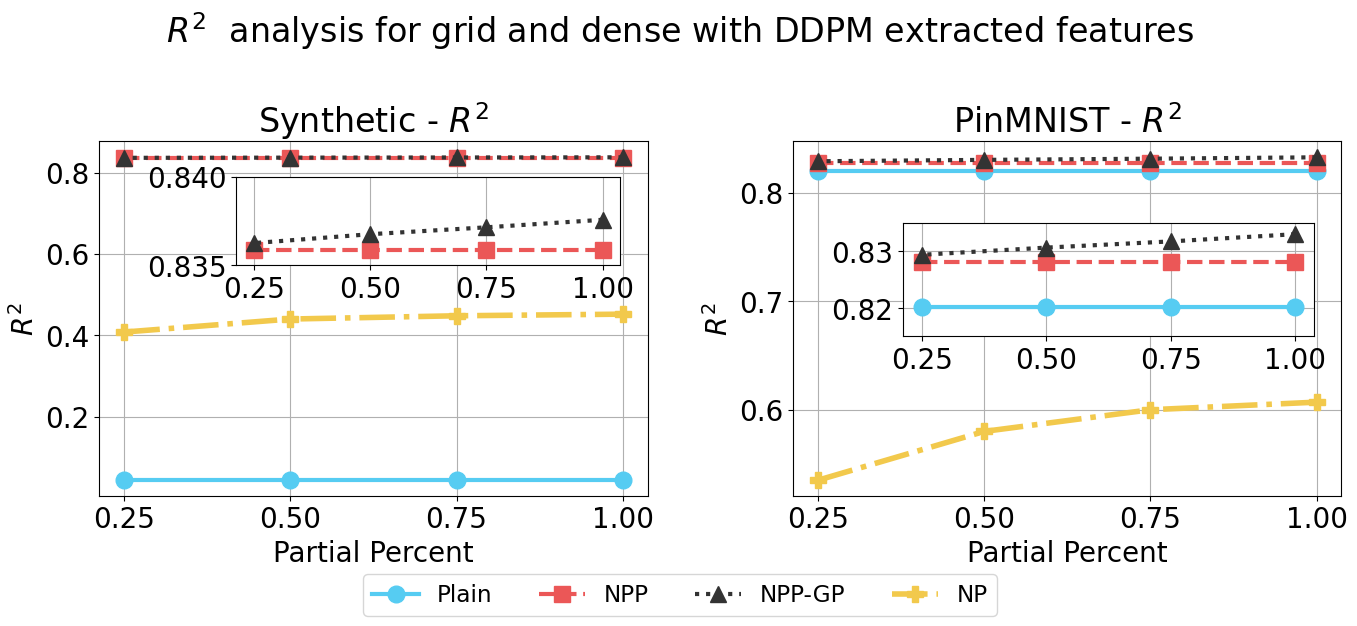

In [89]:
# Correcting the variable naming conflict and trying again
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

font = {'size': 20}

matplotlib.rc('font', **font)

# Filter the DataFrame for rows where Feature is equal to "AE"
df_ae = df[(df['Feature'] == 'DDPM')]

# Settings for visualization
metrics = ['R2']
data_groups = ['MSE', 'NPP']
data_names = ['Plain', 'NPP']
datasets = ['Synthetic', 'PinMNIST']
modes = ['mesh'] #df_ae['Mode'].unique()
npins = [100] #df_ae['NPins'].unique()
mode_name = 'random' if modes[0] == 'random' else 'grid'
density = 'dense' if npins[0] == 100 else 'sparse'
#colors = sns.color_palette("tab10", n_colors=len(modes)*len(npins))
colors= ["#56CCF2", "#EB5757", "#333333", "#F2C94C"] #["#56CCF2", None, "#EB5757", None, "#333333", "#F2C94C"]
linestyles = ['-', '--', ':', '-.']
markers = ['o', 's', '^', 'P']
fig, axs = plt.subplots(len(metrics), len(datasets), figsize=(14, 6), sharex=True)
# Function to plot the lines, with fixed variable naming
def plot_lines(ax, k, metric):
    if k == 2 and modes[0] == 'mesh':
        if npins[0] == 9:
            npins[0] = 16
        if npins[0] == 100:
            npins[0] = 121
    for mode_idx, mode in enumerate(modes):
        for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
            for data_group_idx, data_group in enumerate(data_groups):
                # Filter the dataset for the specific conditions
                df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                    (df_ae['NPins'] == npins_value)]
                if df_filtered.empty:
                    print('HEY')
                label = data_names[data_group_idx]
                color = colors[data_group_idx] #colors[mode_idx * len(npins) + list(sorted(npins)).index(npins_value)]
                linestyle = linestyles[data_group_idx] #linestyles[data_group_idx]
                marker =  markers[data_group_idx] #markers[data_group_idx]
                value = df_filtered[df_filtered['Partial Percent'] == 1.0][data_group].values[0] if metric == 'MSE' else df_filtered[df_filtered['Partial Percent'] == 1.0][f'R2 {data_group}'].values[0]
                ax.plot(x, [value]*len(x),
                        label=label, color=color, linestyle=linestyle, marker=marker, markersize=12, linewidth=3)
    if k == 2:
        ax.plot(x, NPP_GP[j][f"{modes[0]}_{density}"],
                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)
    else:
        df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                    (df_ae['NPins'] == npins_value)]
        ax.plot(df_filtered[df_filtered['Partial Percent'] != 0.0]['Partial Percent'], df_filtered[df_filtered['Partial Percent'] != 0.0][f'R2 GP'],
                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)

        
        
    ax.plot(x, NP[j][f"{modes[0]}_{density}"],
                        label="NP", color=colors[3], linestyle=linestyles[3], marker=markers[3], markersize=12, linewidth=4)
# Re-plotting for each subplot with the corrected function

for j, dataset in enumerate(datasets):
    plot_lines(axs[j], j, metrics[0])
    #if j == 1:
    #    axs[j].set_ylim([0.92, 0.96])
    axs[j].set_title(f'{dataset} - $R^2$')
    axs[j].set_xlabel('Partial Percent')
    axs[j].set_ylabel('$R^2$')
    #axs[j].set_ylim([-1.1,1.1])
    axs[j].set_xticks([0.25, 0.50, 0.75, 1.00])
    #axs[i, j].legend(loc='best', fontsize='small')
    axs[j].grid(True)
    # Add the zoom-in subplot for the second dataset (PinMNIST)
    if j == 0:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.25, 0.65, 0.70, 0.25])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0])
        inset_ax.set_ylim([0.835, 0.840])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)
    if j == 1:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.20, 0.45, 0.75, 0.32])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0])
        inset_ax.set_ylim([0.815, 0.835])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)

handles, labels = axs[0].get_legend_handles_labels()

# Placing a global legend below the subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize='small')
#fig.suptitle(f'$R^2$  analysis for {mode_name} and {density} with DDPM extracted features')
plt.tight_layout()
plt.savefig(f"DDPM_Results_{mode_name}_{density}.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

In [4]:
df[(df['Dataset'] == 'PinMNIST') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True).to_csv('pinMNIST.csv', index=False)
df[(df['Dataset'] == 'PinMNIST') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True)

,Dataset,Feature,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
0,PinMNIST,AE,mesh,100,1.00,0.180671,0.996895,0.2,0.166074,0.997135,0.165522,0.997145
1,PinMNIST,AE,mesh,100,0.75,0.180671,0.996895,0.2,0.166074,0.997135,0.165615,0.997143
2,PinMNIST,AE,mesh,100,0.50,0.180671,0.996895,0.2,0.166074,0.997135,0.165733,0.997141
3,PinMNIST,AE,mesh,100,0.25,0.180671,0.996895,0.2,0.166074,0.997135,0.165913,0.997138
4,PinMNIST,AE,mesh,100,0.00,0.180671,0.996895,0.2,0.166074,0.997135,0.166074,0.997135
5,PinMNIST,AE,mesh,9,1.00,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.971716
6,PinMNIST,AE,mesh,9,0.75,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.971716
7,PinMNIST,AE,mesh,9,0.50,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.976180
8,PinMNIST,AE,mesh,9,0.25,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.976180
9,PinMNIST,AE,mesh,9,0.00,118.606788,-0.641429,0.2,0.066840,0.994037,0.066840,0.994037


In [5]:
df[(df['Dataset'] == 'Synthetic') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True).to_csv('Synthetic.csv', index=False)
df[(df['Dataset'] == 'Synthetic') & (df['Extra layers'] == False)].drop(labels='Extra layers', axis=1).reset_index(drop=True)

,Dataset,Feature,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
0,Synthetic,AE,mesh,100,1.00,13.901962,0.782908,0.5,14.245438,0.777145,14.081051,0.779755
1,Synthetic,AE,mesh,100,0.75,13.901962,0.782908,0.5,14.245438,0.777145,14.123055,0.779089
2,Synthetic,AE,mesh,100,0.50,13.901962,0.782908,0.5,14.245438,0.777145,14.157693,0.778540
3,Synthetic,AE,mesh,100,0.25,13.901962,0.782908,0.5,14.245438,0.777145,14.206275,0.777771
4,Synthetic,AE,mesh,100,0.00,13.901962,0.782908,0.5,14.245438,0.777145,14.245438,0.777145
5,Synthetic,AE,mesh,9,1.00,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
6,Synthetic,AE,mesh,9,0.75,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
7,Synthetic,AE,mesh,9,0.50,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
8,Synthetic,AE,mesh,9,0.25,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756
9,Synthetic,AE,mesh,9,0.00,12.467432,0.552807,0.1,12.470502,0.552756,12.470502,0.552756


TESTING

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tools.plot_utils import plot_and_save
from tools.data_utils import *
from tools.losses import NPPLoss
from tools.models import Autoencoder
from tools.optimization import EarlyStoppingCallback, evaluate_model
import matplotlib.pyplot as plt
import argparse
import time
from tools.models import *

experiment_id = "1709622898" # 1709521764
experiment_folder = "./history/exp_def"
dataset = "Synthetic"
feature = "DDPM"
mode = "random"
feature_extracted = True if feature == "DDPM" else False
mesh = True if mode == "mesh" else False
d = 3
n_pins = 100
partial_percent = 0.25
r = 3
batch_size = 32

num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]


# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

if dataset == "Synthetic":
    input_channel = 3 
elif dataset == "PinMNIST":
    input_channel = 1
elif dataset == "Building":
    input_channel = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if feature_extracted:
    folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
        config['n_pins'] = (28//d + 1)**2
    else:
        data_folder = f"./data/{folder}/random_fixedTrue_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"
elif dataset == "Synthetic":
    folder += "/28by28pixels_1000images_123456seed"
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_pins"
        config['n_pins'] = (28//d + 1)**2
    else:
        data_folder = f"./data/{folder}/random_{n_pins}pins"
else: # dataset == "Building"
    raise Exception("Building option is still not implemented.")

transform = transforms.Compose([
    ToTensor(),         # Convert to tensor (as you were doing)
    Resize()  # Resize to 100x100
])

transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                      root_dir=f"./data/{folder}/images/",
                                      transform=transform)

dataset_size = len(transformed_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.10 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    transformed_dataset, [train_size, val_size, test_size]
)

# Create your DataLoader with the custom_collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)        

In [ ]:
# Testing
dataloader = train_loader

if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth', map_location=device))
        autoencoder_MSE.eval()
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth', map_location=device))
        autoencoder_NPP.eval()
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")

        
hidden_samples = 0.5
for model in [autoencoder_MSE, autoencoder_NPP]:
    total_loss = 0.0
    criterion = NPPLoss(identity=True).to(device)

    with torch.no_grad():
        for batch in dataloader:
            x_test = batch['image'][:, :input_channel, :, :].to(device)
            p_test = [tensor.to(device) for tensor in batch['pins']]
            y_test = [tensor.to(device) for tensor in batch['outputs']]
            test_outputs = model(x_test.float())

            for i in range(len(x_test)):      
                num_samples = int(len(p_test[i]) * hidden_samples)
                p_sample = p_test[i][num_samples:]
                y_sample = y_test[i][num_samples:]
                mu_sample = (test_outputs[i].squeeze())[p_sample[:, 0], p_sample[:, 1]]
                if i == 0:
                    print('GT: ', y_sample)
                    print('OUTPUT: ', mu_sample)
            loss = criterion(y_test, test_outputs, p_test)

            total_loss += loss.item()

    total_loss /= len(dataloader)
    print('TEST LOSS: ', total_loss, '\n\n\n\n')

In [ ]:
# Testing
experiment_id = 1709000615
dataloader = test_loader

if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth', map_location=device))
        autoencoder_MSE.eval()
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth', map_location=device))
        autoencoder_NPP.eval()
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")

        
hidden_samples = 0.5
for model in [autoencoder_MSE, autoencoder_NPP]:
    total_loss = 0.0
    criterion = NPPLoss(identity=True).to(device)

    with torch.no_grad():
        for batch in dataloader:
            x_test = batch['image'][:, :input_channel, :, :].to(device)
            p_test = [tensor.to(device) for tensor in batch['pins']]
            y_test = [tensor.to(device) for tensor in batch['outputs']]
            test_outputs = model(x_test.float())

            for i in range(len(x_test)):      
                num_samples = int(len(p_test[i]) * hidden_samples)
                p_sample = p_test[i][num_samples:]
                y_sample = y_test[i][num_samples:]
                mu_sample = (test_outputs[i].squeeze())[p_sample[:, 0], p_sample[:, 1]]
                if i == 0:
                    print('GT: ', y_sample)
                    print('OUTPUT: ', mu_sample)
            loss = criterion(y_test, test_outputs, p_test)

            total_loss += loss.item()

    total_loss /= len(dataloader)
    print('TEST LOSS: ', total_loss, '\n\n\n\n')

In [ ]:
# Testing
if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth'))
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth'))
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")
    # NPP
    for percent in [0.25, 0.50, 0.75, 1.00]:
        print(f'Percent testing {percent}')
        best_MSE_test_loss = evaluate_model(autoencoder_MSE, test_loader, input_channel, device, partial_label_GP=False, partial_percent=percent)
        best_NPP_test_loss = evaluate_model(autoencoder_NPP, test_loader, input_channel, device, partial_label_GP=False, partial_percent=percent)
        try:
            GP_best_NPP_test_loss = evaluate_model(autoencoder_NPP, test_loader, input_channel, device, partial_label_GP=True, partial_percent=percent)
            # Write output into file
            filename = f"test_{folder.split('/')[0]}_{percent}.txt"
            with open(f"{experiment_folder}/{experiment_id}/{filename}", "w") as f:
                f.write(f"MSE {best_MSE_test_loss}; NPP {best_NPP_test_loss}, {GP_best_NPP_test_loss} (GP)")
        except Exception as Error:
            print(Error)